### Import Modules

In [7]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import numpy as np 
import seaborn as sns


In [8]:
def average_time_between_events(event_vector, time_per_sample):
    """
    Calculates the average duration of non-event periods (0s) that occur
    strictly between event periods (1s).

    Args:
        event_vector (list or numpy array): A sequence of 0s and 1s.
        time_per_sample (float): The duration (e.g., in seconds) represented
                                 by each element in the vector.

    Returns:
        float: The average duration (in the units of time_per_sample)
               between event occurrences. Returns numpy.nan if there are
               fewer than two distinct event periods (i.e., no gaps *between* events).
    """
    if not isinstance(event_vector, (list, np.ndarray)):
        raise TypeError("event_vector must be a list or numpy array")
    if time_per_sample <= 0:
        raise ValueError("time_per_sample must be positive")

    # Group consecutive identical values and get their type (0 or 1) and count
    # Example: [0,0,1,1,0,1] -> [(0, 2), (1, 2), (0, 1), (1, 1)]
    groups = [(key, len(list(group))) for key, group in itertools.groupby(event_vector)]

    gap_lengths = []
    # Iterate through the groups to find sequences of 0s between sequences of 1s
    # We need at least 3 groups (1, 0, 1) to have a gap *between* events
    if len(groups) >= 3:
        for i in range(1, len(groups) - 1):
            prev_key, _ = groups[i-1]
            current_key, current_length = groups[i]
            next_key, _ = groups[i+1]

            # Check if the current group is 0s and surrounded by 1s
            if prev_key == 1 and current_key == 0 and next_key == 1:
                gap_lengths.append(current_length)

    # Calculate durations and the average
    if not gap_lengths:
        # No gaps found between laughter events
        print("No gaps found between laughter events.")
        return np.nan
    else:
        gap_durations = [length * time_per_sample for length in gap_lengths]
        average_duration = np.mean(gap_durations)
        #print(f"Found {len(gap_durations)} gap(s) between laughter events.")
        #print(f"Gap lengths (in samples): {gap_lengths}")
        #print(f"Gap durations (in seconds): {[round(d, 2) for d in gap_durations]}")
        return average_duration, gap_durations

In [ ]:
import os
from pydub import AudioSegment
import pandas as pd

folder_path = '/Volumes/T7 Shield/friends/stimuli/'
mp3_files = []

# Step 1: Find all .mp3 files
for root, dirs, files in os.walk(folder_path):
    for file in files:
        if file.endswith('.mp3') and not file.startswith('._'):
            if file[-5] in ['a', 'b']:  # friends_s01e01a.mp3 → check 'a' or 'b' before '.mp3'
                mp3_files.append(os.path.join(root, file))

mp3_files.sort()

# Step 2: Extract durations
mp3_data = []
for file_path in mp3_files:
    try:
        audio = AudioSegment.from_mp3(file_path)
        duration = len(audio) / 1000.0  # in seconds
        mp3_data.append({
            'file': os.path.basename(file_path),  # e.g. friends_s01e01a.mp3
            'length_sec': round(duration, 2)
        })
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# Step 3: Make DataFrame and extract episode ID
df_durations = pd.DataFrame(mp3_data)
df_durations['episode'] = df_durations['file'].str.extract(r'(s\d{2}e\d{2})')

# Step 4: Aggregate duration per full episode (a + b)
df_episode_lengths = df_durations.groupby('episode', as_index=False)['length_sec'].sum()

df_episode_lengths.head()


In [ ]:
df_durations

### Files and Loading

In [319]:
file_path = '../data/02_laughter/laughter_annotations/'
myFiles = [f for f in os.listdir(file_path) if f.endswith(".csv")]
myFiles.sort()
print(myFiles[:3])

from collections import defaultdict

episode_groups = defaultdict(list)

for fname in myFiles:
    # Extract part suffix: e.g., 'a', 'b', 'c', ...
    part = os.path.splitext(fname)[0][-1]  # last character before '.csv'
    if part not in ['a', 'b']:  #skipping the overlong episodes - simpler for plotting
        continue  # skip 'c', 'd', etc.
    # Extract episode ID: e.g., 's01e15' from 'friends_s01e15a.csv'
    base = fname.split("_")[1][:6]
    episode_groups[base].append(fname)
    
episode_groups

['friends_s01e01a.csv', 'friends_s01e01b.csv', 'friends_s01e02a.csv']


defaultdict(list,
            {'s01e01': ['friends_s01e01a.csv', 'friends_s01e01b.csv'],
             's01e02': ['friends_s01e02a.csv', 'friends_s01e02b.csv'],
             's01e03': ['friends_s01e03a.csv', 'friends_s01e03b.csv'],
             's01e04': ['friends_s01e04a.csv', 'friends_s01e04b.csv'],
             's01e05': ['friends_s01e05a.csv', 'friends_s01e05b.csv'],
             's01e06': ['friends_s01e06a.csv', 'friends_s01e06b.csv'],
             's01e07': ['friends_s01e07a.csv', 'friends_s01e07b.csv'],
             's01e08': ['friends_s01e08a.csv', 'friends_s01e08b.csv'],
             's01e09': ['friends_s01e09a.csv', 'friends_s01e09b.csv'],
             's01e10': ['friends_s01e10a.csv', 'friends_s01e10b.csv'],
             's01e11': ['friends_s01e11a.csv', 'friends_s01e11b.csv'],
             's01e12': ['friends_s01e12a.csv', 'friends_s01e12b.csv'],
             's01e13': ['friends_s01e13a.csv', 'friends_s01e13b.csv'],
             's01e14': ['friends_s01e14a.csv', 'friends_s01

In [351]:
gap_durations_all = []
names_all = []
times_all = []

trs_list = []  # one entry per episode part


for episode_id, file_list in episode_groups.items():
    for curr_file in sorted(file_list):  # keep a < b
        df = pd.read_csv(os.path.join(file_path, curr_file))
        #print(curr_file)
        #print(len(df['ls'].values))
        
        sampling_interval = 1.49
        avg_gap, gap_durations = average_time_between_events(df['ls'].values, sampling_interval)

        episode_label = curr_file[8:14]  # e.g., s01e01a
        names = np.repeat(episode_label, len(gap_durations))
        names_all.append(names)

        gap_durations_all.append(gap_durations)

        times = np.cumsum(gap_durations)
        times_all.append(times)

        trs_list.append({'episode': episode_label, 'trs': len(df['ls'].values)})



names_flat = np.concatenate(names_all)
gaps_flat = np.concatenate(gap_durations_all)
times_flat = np.concatenate(times_all)


df_laughter = pd.DataFrame()
df_laughter['episode'] = names_flat
df_laughter['ili'] = gaps_flat
df_laughter['times'] = times_flat
df_laughter['season'] = df_laughter['episode'].str.extract(r'(s\d{2})')

# Merge durations
df_laughter = df_laughter.merge(df_episode_lengths, on='episode', how='left')

df_trs = pd.DataFrame(trs_list)
df_trs['episode_base'] = df_trs['episode'].str.extract(r'(s\d{2}e\d{2})')
df_trs_by_episode = df_trs.groupby('episode_base')['trs'].sum().reset_index()
df_trs_by_episode.columns = ['episode', 'trs']
df_trs_by_episode['season'] = df_trs_by_episode['episode'].str.extract(r'(s\d{2})')

df_trs_by_episode['secs'] = df_trs_by_episode['trs'] * 1.49
df_trs_by_episode.head()

df_laughter['episode_base'] = df_laughter['episode'].str.extract(r'(s\d{2}e\d{2})')
df_laughter = df_laughter.merge(df_trs_by_episode, on='episode', how='left')
df_laughter['season'] = df_laughter['episode'].str.extract(r'(s\d{2})')

df_laughter

,episode,ili,times,season_x,length_sec,episode_base,trs,season_y,secs,season
0,s01e01,8.94,8.94,s01,1760.62,s01e01,1183,s01,1762.67,s01
1,s01e01,2.98,11.92,s01,1760.62,s01e01,1183,s01,1762.67,s01
2,s01e01,1.49,13.41,s01,1760.62,s01e01,1183,s01,1762.67,s01
3,s01e01,4.47,17.88,s01,1760.62,s01e01,1183,s01,1762.67,s01
4,s01e01,4.47,22.35,s01,1760.62,s01e01,1183,s01,1762.67,s01
...,...,...,...,...,...,...,...,...,...,...
18716,s06e24,2.98,452.96,s06,1366.27,s06e24,918,s06,1367.82,s06
18717,s06e24,17.88,470.84,s06,1366.27,s06e24,918,s06,1367.82,s06
18718,s06e24,5.96,476.80,s06,1366.27,s06e24,918,s06,1367.82,s06
18719,s06e24,10.43,487.23,s06,1366.27,s06e24,918,s06,1367.82,s06


In [352]:
summary_df1 = df_laughter.groupby("episode")["ili"].agg(["mean", "median","max", "std", "count", "sum"])
summary_df1

,mean,median,max,std,count,sum
episode,,,,,,
s01e01,7.102036,5.96,44.70,6.655341,167,1186.04
s01e02,6.820889,5.96,44.70,5.868865,135,920.82
s01e03,7.541692,5.96,34.27,5.732606,130,980.42
s01e04,6.860000,5.96,19.37,4.698463,149,1022.14
s01e05,7.773411,5.96,34.27,5.833406,129,1002.77
...,...,...,...,...,...,...
s06e20,6.601846,4.47,44.70,6.186525,130,858.24
s06e21,6.854000,5.96,44.70,5.560152,140,959.56
s06e22,7.559024,5.96,49.17,6.910612,123,929.76


In [353]:
#summary_df = df_laughter.groupby("episode")["times"].agg(["mean", "median", "max", "std", "count", "sum"])
#summary_df
df_laughter['season'] = df_laughter['episode'].str.extract(r'(s\d{2})')
df_laughter

,episode,ili,times,season_x,length_sec,episode_base,trs,season_y,secs,season
0,s01e01,8.94,8.94,s01,1760.62,s01e01,1183,s01,1762.67,s01
1,s01e01,2.98,11.92,s01,1760.62,s01e01,1183,s01,1762.67,s01
2,s01e01,1.49,13.41,s01,1760.62,s01e01,1183,s01,1762.67,s01
3,s01e01,4.47,17.88,s01,1760.62,s01e01,1183,s01,1762.67,s01
4,s01e01,4.47,22.35,s01,1760.62,s01e01,1183,s01,1762.67,s01
...,...,...,...,...,...,...,...,...,...,...
18716,s06e24,2.98,452.96,s06,1366.27,s06e24,918,s06,1367.82,s06
18717,s06e24,17.88,470.84,s06,1366.27,s06e24,918,s06,1367.82,s06
18718,s06e24,5.96,476.80,s06,1366.27,s06e24,918,s06,1367.82,s06
18719,s06e24,10.43,487.23,s06,1366.27,s06e24,918,s06,1367.82,s06


In [374]:
summary_df = df_laughter.groupby("episode").agg({
    "ili": ["count", "mean", "std"],
    "length_sec": "first"  # or max
}).reset_index()

summary_df.columns = ['episode', 'num_laughs', 'ili_mean', 'ili_std', 'length_sec']
summary_df = summary_df.merge(df_trs_by_episode, on='episode', how='left')
summary_df = summary_df.groupby("season").agg({
                        "num_laughs": ["sum"],
                        "secs": "sum"  
                    }).reset_index()
summary_df.columns = ['season', 'num_laughs', 'secs']

summary_df['lpm'] = summary_df['num_laughs']/(summary_df['secs']/60)
summary_df

,season,num_laughs,secs,lpm
0,s01,3164,34690.18,5.472442
1,s02,2998,33660.59,5.343935
2,s03,3264,34809.38,5.626070
3,s04,2949,31801.07,5.563964
4,s05,3108,32791.92,5.686767
5,s06,3238,32088.64,6.054479


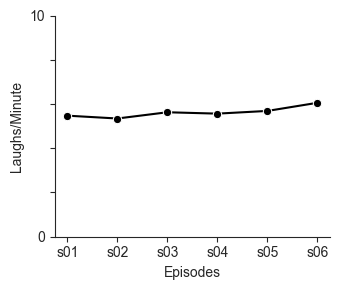

In [394]:
sns.set_style('ticks')

plt.figure(figsize = (3.5,3.))
sns.lineplot(data=summary_df, x="season", y="lpm", marker="o", color = 'black')
plt.xlabel("Episodes")
plt.ylabel("Laughs/Minute")
plt.ylim(0, 10)  
plt.yticks([0, 2, 4, 6, 8, 10], ['0', '', '', '', '', '10'])
#plt.xticks([0, 2, 4, 6, 8, 10], ['0', '', '', '', '', '10'])

plt.grid(False)
sns.despine()
plt.tight_layout()
plt.show()


In [326]:
#g = sns.FacetGrid(df_laughter, col="episode", col_wrap=6, height=2.5)
#g.map(sns.histplot, "ili", bins=20)

In [327]:
#plt.figure(figsize=(14, 5))
#sns.violinplot(data=df_laughter, x="episode", y="ili", inner="quartile", scale="width")
#plt.xticks(rotation=90)
#plt.ylabel("Inter-Laugh Gap (s)")

In [328]:
#df_laughter["laugh_rate"] = 1 / df_laughter["ili"]
#sns.lineplot(data=df_laughter, x="episode", y="laugh_rate", hue="episode")

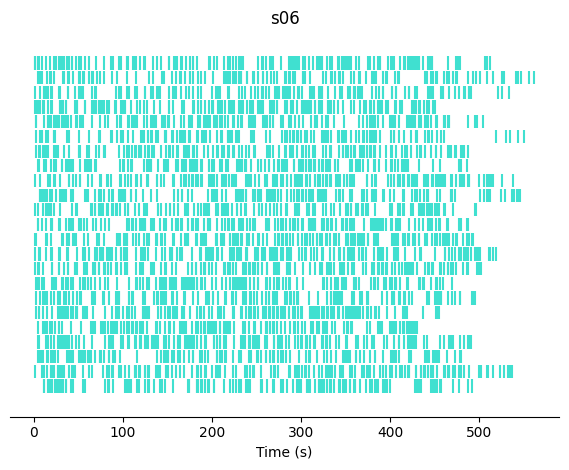

In [335]:
# Filter for a specific season
season_of_interest = 's06'
df_season = df_laughter[df_laughter["season"] == season_of_interest]

# Group by episode and sort laugh times
episode_laughs_series = df_season.groupby("episode")["times"].apply(np.sort)
episode_laughs_series = episode_laughs_series.sort_index()  # optional: order episodes by name

episode_labels = episode_laughs_series.index
episode_laughs = episode_laughs_series.tolist()

# Reverse lineoffsets
lineoffsets = range(len(episode_laughs)-1, -1, -1)

plt.eventplot(episode_laughs, orientation='horizontal', colors='turquoise',
              lineoffsets=lineoffsets, linelengths=0.9);

plt.yticks(ticks=lineoffsets, labels=episode_labels);
plt.xlabel("Time (s)")
plt.title(f"{season_of_interest}")
plt.tight_layout()

sns.despine()
ax = plt.gca()
ax.spines['left'].set_visible(False)   # hide y-axis line
ax.tick_params(axis='y', left=False, labelleft=False)  # remove ticks and labels
plt.show()

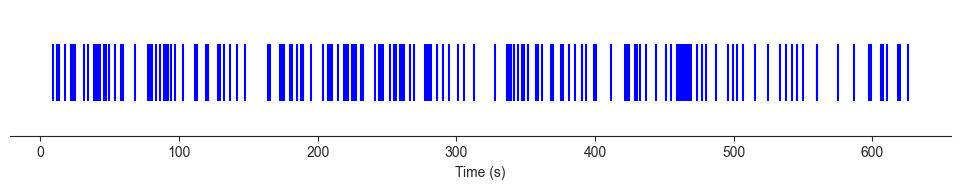

In [395]:
# Filter for a specific season
df_episode = df_laughter[df_laughter["episode"] == 's01e01']

df_episode = df_laughter[df_laughter["episode"] == 's01e01']
episode_laughs_series = df_episode["times"].values
episode_laughs_series

#episode_labels = episode_laughs_series.index
episode_laughs = episode_laughs_series.tolist()

# Reverse lineoffsets
#lineoffsets = range(len(episode_laughs)-1, -1, -1)

plt.figure(figsize = (10,2))
plt.eventplot(episode_laughs, 
              orientation='horizontal', 
              colors='blue',
              #lineoffsets=lineoffsets, 
              linelengths=0.9);

#plt.yticks(ticks=lineoffsets, labels=episode_labels);
plt.xlabel("Time (s)")
#plt.title(f"{season_of_interest}")
plt.tight_layout()

sns.despine()
ax = plt.gca()
ax.spines['left'].set_visible(False)   # hide y-axis line
ax.tick_params(axis='y', left=False, labelleft=False)  # remove ticks and labels
plt.show()

In [396]:
df_episode

,episode,ili,times,season_x,length_sec,episode_base,trs,season_y,secs,season
0,s01e01,8.94,8.94,s01,1760.62,s01e01,1183,s01,1762.67,s01
1,s01e01,2.98,11.92,s01,1760.62,s01e01,1183,s01,1762.67,s01
2,s01e01,1.49,13.41,s01,1760.62,s01e01,1183,s01,1762.67,s01
3,s01e01,4.47,17.88,s01,1760.62,s01e01,1183,s01,1762.67,s01
4,s01e01,4.47,22.35,s01,1760.62,s01e01,1183,s01,1762.67,s01
...,...,...,...,...,...,...,...,...,...,...
162,s01e01,1.49,607.92,s01,1760.62,s01e01,1183,s01,1762.67,s01
163,s01e01,2.98,610.90,s01,1760.62,s01e01,1183,s01,1762.67,s01
164,s01e01,7.45,618.35,s01,1760.62,s01e01,1183,s01,1762.67,s01
165,s01e01,1.49,619.84,s01,1760.62,s01e01,1183,s01,1762.67,s01


In [400]:
1760/60

29.333333333333332

In [398]:
(166/1760)*60

5.659090909090909